In [414]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import numpy as np
from scipy.interpolate import make_interp_spline
from sklearn.model_selection import train_test_split
from gpytorch.kernels import Kernel
import pickle
from sklearn.preprocessing import StandardScaler
from gpytorch.means import Mean
from sklearn.metrics import mean_squared_error
from gpytorch.kernels import Kernel, RBFKernel,ScaleKernel
from gpytorch.constraints import Interval
from gpytorch.settings import cholesky_jitter
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution, VariationalStrategy
from gpytorch.kernels import ScaleKernel, RBFKernel

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [415]:


df = pd.read_csv('GDSC1_melanoma_BRAF_5conc_noreps_v3.csv')
X_df = df[['param_1', 'param_2', 'param_3',
       'param_4','ARID1A_mut', 'ARID2_mut', 'BRAF_mut', 'CDKN2A_mut',
       'EZH2_mut', 'MECOM_mut', 'NF1_mut', 'NRAS_mut', 'PLCB1_mut', 'PTEN_mut',
       'TP53_mut', 'loss.cnaSKCM3', 'loss.cnaSKCM4..BNC2.CDKN2A.JAK2.PSIP1.',
       'loss.cnaSKCM5..PAX5.', 'loss.cnaSKCM9', 'gain.cnaSKCM12..KRAS.',
       'gain.cnaSKCM21..FOXP1.MITF.', 'loss.cnaSKCM22', 'loss.cnaSKCM23',
       'loss.cnaSKCM24..loss.cnaSKCM25', 'loss.cnaSKCM26',
       'loss.cnaSKCM27..CASP1.', 'loss.cnaSKCM28', 'loss.cnaSKCM30']]
y_df = df[['norm_cells_1', 'norm_cells_2', 'norm_cells_3',
       'norm_cells_4', 'norm_cells_5']]





# X_train, X_test, y_train, y_test= train_test_split(X_df, y_df, test_size=0.1, random_state=42)

def load_dataset(X_path,y_path,X_domain_path=None,do_standardisation=False,test_size=0.2,random_state=42):
    X_df=None
    X_domain_info=None
    y_df=None
    with open(X_path, 'rb') as f:
        X_df = pickle.load(f)
    with open(y_path, 'rb') as f:
        y_df = pickle.load(f)
    print(X_df.shape)
    print(y_df.shape)
    if X_domain_path!=None:
        with open(X_domain_path, 'rb') as f:
            X_domain_info = pickle.load(f)
        print(X_domain_info.shape)
        X_train, X_test, y_train, y_test,X_D_train,X_D_test = train_test_split(X_df, y_df,X_domain_info, test_size=test_size, random_state=random_state)
    else:
        X_train, X_test, y_train, y_test= train_test_split(X_df, y_df, test_size=test_size, random_state=random_state)
    X_train = np.array(X_train, dtype=np.float32)
    y_train = np.array(y_train, dtype=np.float32)

    if X_domain_path!=None:
        X_D_train = np.array(X_D_train, dtype=np.float32)
        X_D_test = np.array(X_D_test, dtype=np.float32)

    X_test = np.array(X_test, dtype=np.float32)
    y_test = np.array(y_test, dtype=np.float32)
    if do_standardisation:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

    X_train_tensor = torch.tensor(X_train)
    y_train_tensor = torch.tensor(y_train)
    if X_domain_path!=None:
        X_D_train_tensor = torch.tensor(X_D_train)
        X_D_test_tensor = torch.tensor(X_D_test)

    X_test_tensor = torch.tensor(X_test)
    y_test_tensor = torch.tensor(y_test)

    if X_domain_path!=None: 
        return (X_train_tensor,X_D_train_tensor,y_train_tensor),(X_test_tensor,X_D_test_tensor,y_test_tensor)
    else:
        return (X_train_tensor,y_train_tensor),(X_test_tensor,y_test_tensor)
    
# X_path="data/X_df_toy.pkl"
# y_path="data/y_df_toy.pkl"

X_path="data/X_df_Shikonin.pkl"
y_path="data/y_df_Shikonin.pkl"
X_domain_path="data/X_domain_info_Shikonin.pkl"
(X_train_tensor,X_D_train_tensor,y_train_tensor),(X_test_tensor,X_D_test_tensor,y_test_tensor)=load_dataset(X_path,y_path,do_standardisation=True,X_domain_path="data/X_domain_info_Shikonin.pkl")

print(X_train_tensor.shape)
print(X_D_train_tensor.shape)
print(y_train_tensor.shape)



num_conc=y_train_tensor.shape[1]

num_feat=X_train_tensor.shape[1]
num_domain_feat=X_D_train_tensor.shape[1]
nums_domain, max_indices_row = torch.max(X_D_train_tensor, dim=0)
nums_domain.add_(1)
print(nums_domain.item())
nums_domain_as_int=nums_domain.long()
X_train_tensor = torch.cat((X_D_train_tensor, X_train_tensor), dim=1)
print(X_train_tensor.shape)
X_test_tensor = torch.cat((X_D_test_tensor, X_test_tensor), dim=1)
print(X_test_tensor.shape)



(274, 1084)
(274, 10)
(274, 1)
torch.Size([219, 1084])
torch.Size([219, 1])
torch.Size([219, 10])
30.0
torch.Size([219, 1085])
torch.Size([55, 1085])


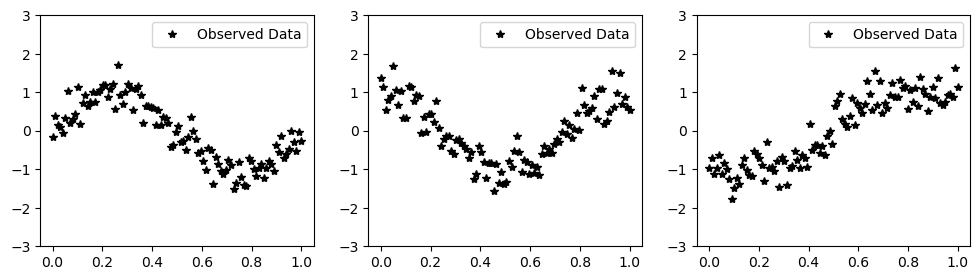

In [416]:

USE_TOY_DATASET=True

if USE_TOY_DATASET:
    VAR=0.09
    AMP=1.0
    train_size=100

    X_sin=torch.linspace(0, 1, train_size)
    X_cos=torch.linspace(0, 1, train_size)
    X_sig=torch.linspace(0, 1, train_size)
    y_sin = AMP*torch.sin(X_sin * (2 * math.pi)) + torch.randn(X_sin.size()) * math.sqrt(VAR)
    y_cos = AMP*torch.cos(X_cos * (2 * math.pi)) + torch.randn(X_cos.size()) * math.sqrt(VAR)
    y_sig = AMP*(torch.sigmoid(15*(X_sig-0.5))-0.5)*2+torch.randn(X_cos.size()) * math.sqrt(VAR)
    # Training data is 100 points in [0,1] inclusive regularly spaced
    X_train_tensor = torch.linspace(0, 1, train_size)
    # True function is sin(2*pi*x) with Gaussian noise

    num_conc=1
    num_feat=1
    nums_domain=torch.Tensor([3])
    num_data=train_size

    X_sin = X_sin.unsqueeze(1)
    X_cos = X_cos.unsqueeze(1)
    X_sig = X_sig.unsqueeze(1)
    y_sin = y_sin.unsqueeze(1)
    y_cos = y_cos.unsqueeze(1)
    y_sig = y_sig.unsqueeze(1)

    X_sin_domain=torch.zeros(train_size,1)
    X_cos_domain=torch.ones(train_size,1)
    X_sig_domain=torch.ones(train_size,1)*2
    X_sin_cat = torch.cat((X_sin_domain, X_sin), dim=1)
    X_cos_cat = torch.cat((X_cos_domain, X_cos), dim=1)
    X_sig_cat = torch.cat((X_sig_domain, X_sig), dim=1)
    X_train_tensor = torch.cat((X_sin_cat, X_cos_cat,X_sig_cat), dim=0)
    y_train_tensor = torch.cat((y_sin, y_cos,y_sig), dim=0)

    f, ax = plt.subplots(1, 3, figsize=(12, 3))
    for i in range(3):
        ax[i].plot(X_train_tensor[i*train_size:(i+1)*train_size,1:].squeeze().numpy(),y_train_tensor[i*train_size:(i+1)*train_size], 'k*')
        axis=X_train_tensor[i*train_size:(i+1)*train_size,1:].flatten().numpy()
        ax[i].set_ylim([-3, 3])
        ax[i].legend(['Observed Data', 'Mean', 'Confidence'])

    # indices = torch.randperm(X_train_tensor.size(0))
    # X_train_tensor = X_train_tensor[indices]
    # y_train_tensor = y_train_tensor[indices]

    test_size=50
    X_sin=torch.linspace(0, 1, test_size)
    X_cos=torch.linspace(0, 1, test_size)
    X_sig=torch.linspace(0, 1, test_size)

    X_sin_domain=torch.zeros(test_size,1)
    X_cos_domain=torch.ones(test_size,1)
    X_sig_domain=torch.ones(test_size,1)*2

    X_sin = X_sin.unsqueeze(1)
    X_cos = X_cos.unsqueeze(1)
    X_sig = X_sig.unsqueeze(1)

    y_sin =AMP* torch.sin(X_sin * (2 * math.pi)) + torch.randn(X_sin.size()) * math.sqrt(VAR)
    y_cos =AMP* torch.cos(X_cos * (2 * math.pi)) + torch.randn(X_cos.size()) * math.sqrt(VAR)
    y_sig =AMP* (torch.sigmoid(15*(X_sig-0.5))-0.5)*2+torch.randn(X_cos.size()) * math.sqrt(VAR)

    X_sin_cat = torch.cat((X_sin_domain, X_sin), dim=1)
    X_cos_cat = torch.cat((X_cos_domain, X_cos), dim=1)
    X_sig_cat = torch.cat((X_sig_domain, X_sig), dim=1)

    # X_test_tensor =X_sin_cat
    # y_test_tensor =y_sin
    
    X_test_tensor = torch.cat((X_sin_cat, X_cos_cat,X_sig_cat), dim=0)
    y_test_tensor = torch.cat((y_sin, y_cos,y_sig), dim=0)

    # X_test_tensor = torch.cat((X_sin_cat, X_cos_cat), dim=0)
    # y_test_tensor = torch.cat((y_sin, y_cos), dim=0)




In [417]:
with open(X_path, 'rb') as f:
    X_df = pickle.load(f)
mask_bool_met = X_df.columns.str.contains("HypMET")
mask_bool_mut = X_df.columns.str.contains("mut")
mask_bool_cna = X_df.columns.str.contains("cna")
mask_bool_dc  = X_df.columns.str.contains("dc")

mask_float_met = np.array(mask_bool_met, dtype=np.float32) 
mask_float_mut = np.array(mask_bool_mut, dtype=np.float32)
mask_float_cna = np.array(mask_bool_cna, dtype=np.float32)
mask_float_dc  = np.array(mask_bool_dc, dtype=np.float32)

diag_matrix_met = torch.tensor(np.diag(mask_float_met))
diag_matrix_mut = torch.tensor(np.diag(mask_float_mut))
diag_matrix_cna = torch.tensor(np.diag(mask_float_cna))
diag_matrix_dc  = torch.tensor(np.diag(mask_float_dc))
filters=(diag_matrix_mut,diag_matrix_met,diag_matrix_cna,diag_matrix_dc)
print("MUT features:"+str(np.sum(mask_float_mut))+str(diag_matrix_met.shape))
print("Met features:"+str(np.sum(mask_float_met))+str(diag_matrix_met.shape))
print("CNA features:"+str(np.sum(mask_float_cna))+str(diag_matrix_met.shape))
print("DC features:"+str(np.sum(mask_float_dc))+str(diag_matrix_met.shape))

MUT features:310.0torch.Size([1084, 1084])
Met features:338.0torch.Size([1084, 1084])
CNA features:425.0torch.Size([1084, 1084])
DC features:0.0torch.Size([1084, 1084])


In [418]:
class Kernel_Exponential_Squared(Kernel):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.height_scales=torch.nn.Parameter(torch.ones((nums_domain.long())))
        self.length_scales=torch.nn.Parameter(torch.ones((nums_domain.long())))
        self.register_constraint("height_scales", gpytorch.constraints.Positive())
        self.register_constraint("length_scales", gpytorch.constraints.Positive())    
        
    def forward(self, x1, x2, diag=False, last_dim_is_batch=False, **params):
        x1_domain   =   x1[:, :num_domain_feat]
        x1_genetics =   x1[:, num_domain_feat:]
        x2_domain   =   x2[:, :num_domain_feat]
        x2_genetics =   x2[:, num_domain_feat:]

        # x1_domain   =   x1[:, :num_domain_feat]
        # x1_genetics =   x1
        # x2_domain   =   x2[:, :num_domain_feat]
        # x2_genetics =   x2

        dist_mat=self.covar_dist(x1_genetics, x2_genetics, square_dist=True, diag=diag, **params)

        height_scales_parsed_1 = self.height_scales[x1_domain.long()].flatten()
        height_scales_parsed_2 = self.height_scales[x2_domain.long()].flatten()
        length_scales_parsed_1 = self.length_scales[x1_domain.long()].flatten()
        length_scales_parsed_2 = self.length_scales[x2_domain.long()].flatten()


        # print(f"height_scales_parsed_1: {height_scales_parsed_1.shape}")
        # print(f"height_scales_parsed_2: {height_scales_parsed_2.shape}")
        # print(f"length_scales_parsed_1: {length_scales_parsed_1.shape}")
        # print(f"length_scales_parsed_2: {length_scales_parsed_2.shape}")
        part_L1L2T=torch.outer(length_scales_parsed_1,length_scales_parsed_2.T)
        part_L1L1T=length_scales_parsed_1*length_scales_parsed_1
        part_L2L2T=length_scales_parsed_2*length_scales_parsed_2
        part_L1sqrL2sqr=torch.outer(part_L1L1T,torch.ones_like(part_L2L2T).T)+torch.outer(torch.ones_like(part_L1L1T),part_L2L2T)

        # print(part_L1L2T.shape)
        # print(part_L1L1T.shape)
        # print(part_L2L2T.shape)
        # print(part_L1sqrL2sqr.shape)

        part_1=torch.outer(height_scales_parsed_1,height_scales_parsed_2.T)
        part_2=torch.sqrt(2*part_L1L2T/part_L1sqrL2sqr)
        part_3=torch.exp(-dist_mat/part_L1sqrL2sqr)

        result=part_1*part_2*part_3
        return result

In [419]:
class K_MS(Kernel):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.domain_coefficient=torch.nn.Parameter(torch.rand((nums_domain.long()))*2-1)
        self.register_constraint("domain_coefficient", gpytorch.constraints.Interval(-1,1))
        self.K_ES=Kernel_Exponential_Squared()
        
    def forward(self, x1, x2, diag=False, last_dim_is_batch=False, **params):
        x1_domain   =   x1[:, :num_domain_feat]
        x2_domain   =   x2[:, :num_domain_feat]

        domain_coefficient_parsed_1=self.domain_coefficient[x1_domain.long()].flatten()
        domain_coefficient_parsed_2=self.domain_coefficient[x2_domain.long()].flatten()
        domain_scaler=torch.outer(domain_coefficient_parsed_1,domain_coefficient_parsed_2.T)

        domain_mat=torch.outer(x1_domain.flatten()+1,1/(x2_domain.flatten().T+1))
        mask = (domain_mat == 1.0)

        # 等于1的位置置0
        domain_mat[mask] = 0.0

        # 不等于1的位置置1
        domain_mat[~mask] = 1.0
        # print(domain_scaler)

        
        base_cov=self.K_ES(x1,x2,diag=diag, last_dim_is_batch=last_dim_is_batch, **params)

        final_scaler=(domain_scaler-1.0)*domain_mat+1.0
        return base_cov*final_scaler

In [420]:
class Transferable_Quadriple_Kernel(Kernel):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        # self.kernel_mu = gpytorch.kernels.RBFKernel()
        # self.kernel_met = gpytorch.kernels.RBFKernel()
        # self.kernel_cn = gpytorch.kernels.RBFKernel()
        # # self.kernel_dc = gpytorch.kernels.RBFKernel()
        # self.filter_mu,self.filter_met,self.filter_cn,self.filter_dc=filters
        self.temp=RBFKernel()
        initial_value = torch.ones(nums_domain.long())
        self.domain_relateness = torch.nn.Parameter(initial_value)

        # 使用 softplus 变换来确保参数为正值
        self.register_constraint("domain_relateness", gpytorch.constraints.Positive())
        
    def forward(self, x1, x2, diag=False, last_dim_is_batch=False, **params):
        x1_domain   =   x1[:, :num_domain_feat]
        x1_genetics =   x1[:, num_domain_feat:]
        x2_domain   =   x2[:, :num_domain_feat]
        x2_genetics =   x2[:, num_domain_feat:]
        # # Apply the base kernel
        # filter_mu=self.filter_mu
        # filter_met=self.filter_met
        # filter_cn=self.filter_cn
        # filter_dc=self.filter_dc
        
        # x1_mu   =   x1_genetics @ filter_mu
        # x1_met  =   x1_genetics @ filter_met
        # x1_cn   =   x1_genetics @ filter_cn
        # x1_dc   =   x1_genetics @ filter_dc

        # x2_mu   =   x2_genetics @ filter_mu
        # x2_met  =   x2_genetics @ filter_met
        # x2_cn   =   x2_genetics @ filter_cn
        # x2_dc   =   x2_genetics @ filter_dc

        domain_relateness_multiplier=self.domain_relateness
        # 获取领域系数
        domain_factors1 = self.domain_relateness[x1_domain.long()]
        domain_factors2 = self.domain_relateness[x2_domain.long()]

        # base_cov=self.kernel_mu(x1_mu,x2_mu)*self.kernel_met(x1_met,x2_met)*self.kernel_cn(x1_cn,x2_cn)* 1#self.kernel_dc(x1_dc,x2_dc)
        base_cov=self.temp(x1_genetics,x2_genetics)
        # print(f"Base kernel:{base_cov.shape}")
        if diag:
            adjusted_cov = base_cov * (domain_factors1 * domain_factors2).squeeze()
            # print(f"Diag Adjusted kernel:{adjusted_cov.shape}")
        else:
            factor= (domain_factors1 @ domain_factors2.T)
            adjusted_cov = base_cov *factor
            # print(f"Non-diag Adjusted kernel:{adjusted_cov.shape}")
            # print(f"factor:{factor.shape}")
            # print(f"domain_factors1:{domain_factors1.shape}")
            # print(f"domain_factors2:{domain_factors2.shape}")
        return adjusted_cov

In [421]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    #TODO add input for domain information
    def __init__(self, train_x, train_y,likelihood,):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=num_conc
        )
        self.covar_module = gpytorch.kernels.LCMKernel(
            [K_MS(),  # 2 latent GP's
             K_MS()],
            num_tasks=num_conc, rank=num_conc-1
        )

        
        if USE_TOY_DATASET:
            self.covar_module = gpytorch.kernels.LCMKernel(
                [K_MS(),  # 2 latent GP's
             K_MS(),K_MS()], num_tasks=num_conc,rank=num_conc
            )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)




In [422]:
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=num_conc,has_global_noise=True)
likelihood.noise_covar.noise = torch.tensor(0.1)
model = MultitaskGPModel(X_train_tensor, y_train_tensor, likelihood)


# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iterations = 2 if smoke_test else 300


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# # 定义学习率调度器 (每50个epoch衰减一次学习率)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.5)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
last_loss=1
for i in range(training_iterations):
    optimizer.zero_grad()
    with cholesky_jitter(1e-3):
        output = model(X_train_tensor)
        loss = -mll(output, y_train_tensor)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
    this_loss=loss.item()
    optimizer.step()  # 更新参数
    scheduler.step()  # 更新学习率
    if abs((last_loss-this_loss)/last_loss)<0.001:
        pass
    last_loss=this_loss

AttributeError: 'MultitaskGaussianLikelihood' object has no attribute 'noise_covar'

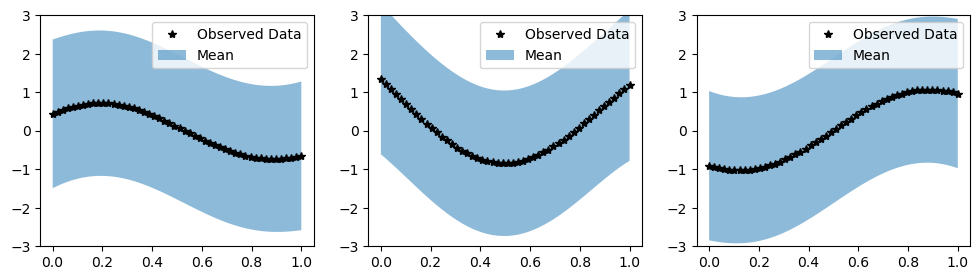

In [ ]:
if USE_TOY_DATASET == True:
    # Get into evaluation (predictive posterior) mode
    model.eval()
    likelihood.eval()

    # Test points are regularly spaced along [0,1]
    # Make predictions by feeding model through likelihood
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        observed_pred = likelihood(model(X_test_tensor))

    with torch.no_grad():
        # Initialize plot
        f, ax = plt.subplots(1, 3, figsize=(12, 3))

        lower, upper = observed_pred.confidence_region()
        mean=observed_pred.mean.numpy()
        for i in range(3):
            ax[i].plot(X_test_tensor[i*50:(i+1)*50,1:].squeeze().numpy(),mean[i*50:(i+1)*50], 'k*')
            ax[i].fill_between(X_test_tensor[i*50:(i+1)*50,1:].flatten().numpy(), lower[i*50:(i+1)*50].squeeze().numpy(), upper[i*50:(i+1)*50].squeeze().numpy(), alpha=0.5)
            ax[i].set_ylim([-3, 3])
            ax[i].legend(['Observed Data', 'Mean', 'Confidence'])


Num 124 Chosen for display


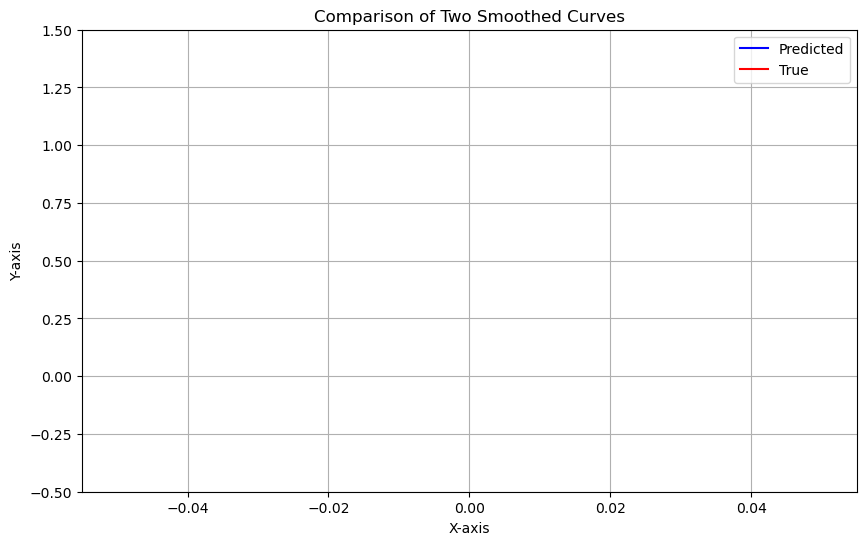

In [ ]:

# Set into eval mode
model.eval()
likelihood.eval()

random_num = np.random.randint(0, len(X_test_tensor), size=1)[0]
y_true=y_test_tensor

# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    distribution = likelihood(model(X_test_tensor))
    mean = distribution.mean
    lower, upper = distribution.confidence_region()


x_plt_axis = torch.tensor(range(num_conc))

# print(x_plt_axis.shape)
# print(mean[0][0].shape)
print("Num "+str(random_num)+" Chosen for display")
# 创建图形、
# print(mean.flatten())

plt.figure(figsize=(10, 6))
plt.plot(x_plt_axis, mean[random_num], label='Predicted', color='blue')
plt.plot(x_plt_axis, y_true[random_num], label='True', color='red')
plt.fill_between(x_plt_axis, lower[random_num], upper[random_num], alpha=0.5)
# 添加标题和标签
plt.title('Comparison of Two Smoothed Curves')
plt.xlabel('X-axis')
plt.ylim(-0.5, 1.5)
plt.ylabel('Y-axis')
plt.legend()
plt.grid(True)



In [ ]:
rmse=torch.sqrt(torch.tensor(mean_squared_error(y_test_tensor.numpy(), mean.numpy()))).item() 
nll = -torch.distributions.Normal(mean, distribution.variance.sqrt()).log_prob(y_test_tensor).mean().item()
nmse = rmse / torch.var(y_test_tensor).item()

print(f'RMSE: {rmse:.4f}')
print(f'NLL: {nll:.4f}')
print(f'NMSE: {nmse:.4f}')

RMSE: 0.3778
NLL: 0.9448
NMSE: 0.6051
